### Load Data

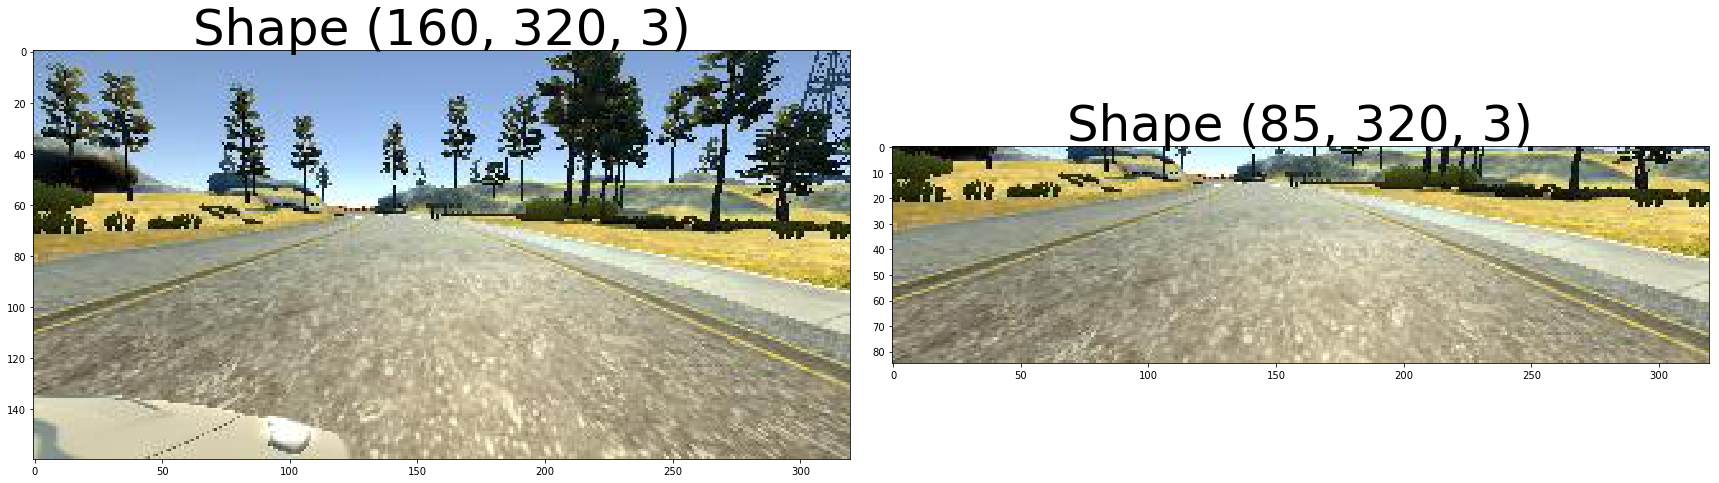

Orig std: 60.1860545413
Norm std: 51.3314
Orig mean: 149.00906901
Norm mean: 150.879


In [2]:
import csv
import cv2
import random
import sklearn
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Cropping2D
from keras import backend as ktf
from sklearn.model_selection import train_test_split
%matplotlib inline

correction = 0.2
samples = []
with open('./data/driving_log.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append((line[0].split('/')[-1], float(line[3])))
        samples.append((line[1].split('/')[-1], float(line[3])+correction))
        samples.append((line[2].split('/')[-1], float(line[3])-correction))
    
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def read_sample(sample):
    image = cv2.cvtColor(cv2.imread('./data/IMG/' + sample[0]), cv2.COLOR_BGR2RGB)
    angle = float(sample[1])
    return image, angle

def compare_images(left_image, right_image):    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(left_image)
    ax1.set_title('Shape '+ str(left_image.shape), fontsize=50)
    ax2.imshow(np.uint8(right_image))
    ax2.set_title('Shape '+ str(right_image.shape), fontsize=50)
    plt.show()
    
    print('Orig std:', np.std(left_image))
    print('Norm std:', np.std(right_image))
    print('Orig mean:', np.mean(left_image))
    print('Norm mean:', np.mean(right_image))
    
image, angle = read_sample(train_samples[0])

model = Sequential()
model.add(Cropping2D(cropping=((50,25),(0,0)), input_shape=(160,320,3)))

new_img = model.predict(image[np.newaxis,...])
new_img = new_img.reshape(new_img.shape[1:])
                    
compare_images(image, new_img)

In [3]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                image = cv2.cvtColor(cv2.imread('./data/IMG/' + batch_sample[0]), cv2.COLOR_BGR2RGB)
                #image = normalize(image)
                angle = float(batch_sample[1])
                images.append(image)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

### Build and Train Model

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

train_generator = generator(train_samples, batch_size=256)
validation_generator = generator(validation_samples, batch_size=256)

model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20),(0,0))))

model.add(Conv2D(6, (5, 5), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(6, (5, 5), activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(120))
model.add(Dropout(0.5))
model.add(Dense(84))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)
model.fit_generator(train_generator, 
                    steps_per_epoch=len(train_samples)/256, 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_samples)/256, 
                    epochs=20)

model.save('model1.h5')

Epoch 1/20
34/33 [==============================] - 23s - loss: 8.5576 - val_loss: 0.0895
Epoch 2/20
34/33 [==============================] - 21s - loss: 0.0875 - val_loss: 0.0391
Epoch 3/20
34/33 [==============================] - 21s - loss: 0.0636 - val_loss: 0.0387
Epoch 4/20
34/33 [==============================] - 21s - loss: 0.0586 - val_loss: 0.0383
Epoch 5/20
34/33 [==============================] - 21s - loss: 0.0554 - val_loss: 0.0379
Epoch 6/20
34/33 [==============================] - 21s - loss: 0.0518 - val_loss: 0.0376
Epoch 7/20
34/33 [==============================] - 21s - loss: 0.0501 - val_loss: 0.0373
Epoch 8/20
34/33 [==============================] - 21s - loss: 0.0468 - val_loss: 0.0369
Epoch 9/20
34/33 [==============================] - 21s - loss: 0.0457 - val_loss: 0.0366
Epoch 10/20
34/33 [==============================] - 21s - loss: 0.0447 - val_loss: 0.0362
Epoch 11/20
34/33 [==============================] - 21s - loss: 0.0434 - val_loss: 0.0358
Epoch 12

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20),(0,0))))

model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [5]:
#model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)
model.fit_generator(train_generator, 
                    steps_per_epoch=len(train_samples)/256, 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_samples)/256, 
                    epochs=5)

model.save('model.h5')

Epoch 1/5
34/33 [==============================] - 21s - loss: 0.0356 - val_loss: 0.0318
Epoch 2/5
34/33 [==============================] - 21s - loss: 0.0351 - val_loss: 0.0315
Epoch 3/5
34/33 [==============================] - 21s - loss: 0.0348 - val_loss: 0.0313
Epoch 4/5
34/33 [==============================] - 21s - loss: 0.0341 - val_loss: 0.0308
Epoch 5/5
34/33 [==============================] - 21s - loss: 0.0338 - val_loss: 0.0305


In [6]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)